# MC integration

This notebook provides a basic Monte Carlo (MC) integration example exploiting
multiple libraries for hardware acceleration.

The integrand is a normalized multi-dimensional gaussian $f(\mathbf{x}) = (2\pi)^{-k/2} \exp (-\sum x_i^2/2)$.

The Monte Carlo estimate of the integral is given by: $I = V \frac{1}{N} \sum_{i=0}^N f(\mathbf{x}_i)$

In [1]:
import numpy as np
dim = 5
num_points = int(1e6)
# generate the array of random points
xarr = np.random.uniform(size=(num_points, dim))

# Numpy

In [2]:
def mc_numpy(xarr: np.ndarray) -> float:
    """
    The integration should be bounded. Consider to integrate from [-a,a].

    :param xarr: input array of random numbers of shape (num_points, num_dims)
    :type xarr: np.ndarray
    """
    # n_points = xarr.shape[0]
    n_dim = xarr.shape[1]
    def integrand_numpy(xarr: np.ndarray):
        a = 0.1
        pref = np.power(np.sqrt(2*np.pi) * a, n_dim)
        coef = ((xarr - 0.5) / a)**2 * 0.5
        return np.exp(-coef.sum(1)) / pref
    
    return integrand_numpy(xarr).mean()

In [37]:
mc_numpy(xarr)

0.9978170599063451

In [3]:
%timeit mc_numpy(xarr)

93 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Pure Python

In [12]:
def mc_python(xarr: np.ndarray) -> float:
    n_points = xarr.shape[0]
    n_dim = xarr.shape[1]
    def num(x, a):
        return ((x - 0.5) / a)**2 * 0.5
    def integrand_python(x):
        a = 0.1
        pref = np.power(np.sqrt(2*np.pi) * a, n_dim)
        coef = sum(num(d, a) for d in x)
        return np.exp(-coef) / pref

    return sum(integrand_python(x) for x in xarr) / n_points

In [13]:
mc_python(xarr)

0.9978170599058755

In [14]:
%timeit mc_python(xarr)

10.5 s ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Numba

:warning: The use of the generator to compute the mean is not supported by numba yet

In [20]:
from numba import njit

@njit
def mc_numba(xarr: np.ndarray) -> float:
    n_points = xarr.shape[0]
    n_dim = xarr.shape[1]
    integral = 0
    def integrand_python(x):
        a = 0.1
        pref = np.power(np.sqrt(2*np.pi) * a, n_dim)
        coef = 0
        for d in x:
            coef += ((d - 0.5) / a)**2 * 0.5
        return np.exp(-coef) / pref
    for i in range(n_points):
        integral += integrand_python(xarr[i])
    return integral / n_points

In [36]:
mc_numba(xarr)

0.9978170599058755

In [21]:
%timeit mc_numba(xarr)

28.9 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Tensorflow

In [33]:
import tensorflow as tf

def float_me(i):
    """Cast the input to the `DTYPE` type"""
    return tf.cast(i, dtype=tf.float32)

@tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
def mc_tf(xarr):

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
    def integrand_tf(xarr):
        n_dim = float_me(tf.shape(xarr)[-1])
        a = float_me(0.1)
        pref = tf.pow(np.sqrt(2 * np.pi) * a, n_dim)
        coef = tf.reduce_sum(tf.square((xarr - 0.5) / a) * 0.5, axis=1)
        return tf.exp(-coef) / float_me(pref)

    return tf.reduce_mean(integrand_tf(xarr))

In [34]:
mc_tf(xarr)

<tf.Tensor: shape=(), dtype=float32, numpy=0.99781686>

In [35]:
%timeit mc_tf(xarr)

32.6 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Plot results

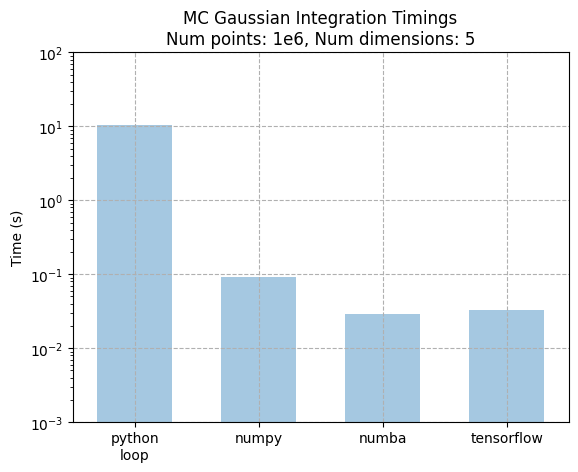

In [45]:
import matplotlib.pyplot as plt
labels = ['python\nloop', 'numpy', 'numba', 'tensorflow']
timings = [10.5, 0.093, 0.0289, 0.0326]
errors = [0.166, 2.94e-3, 2.18e-3, 1.98e-3]
x = np.arange(len(labels))

ax = plt.axes(xticks=x, yscale='log')
ax.bar(x, timings, width=0.6, alpha=0.4, bottom=1e-6)
ax.grid(linestyle="dashed")
ax.set_xlim(-0.5, len(labels) - 0.5)
ax.set_ylim(1E-3, 1E2)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda i, loc: labels[int(i)]))
ax.set_ylabel('Time (s)')
ax.set_title("MC Gaussian Integration Timings\nNum points: 1e6, Num dimensions: 5")
plt.show()